# Solve surface volatiles according to outgassing+chemistry

In [78]:
import sys
sys.path.append("..") 
from src.proteus.utils.surface_gases import (
    CalculateMantleMass,
    get_target_from_params,
    equilibrium_atmosphere,
)
from src.proteus.utils.constants import (
    molar_mass,
    ocean_moles,
    volatile_species,
)

from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline

### Set up initial options dict

In [79]:
OPTIONS = {}

OPTIONS['Phi_global'] = 1.0
OPTIONS['T_magma'] = 2500.0

OPTIONS['radius'] = 6.371e6 * 1.875
OPTIONS['mass']   = 5.972e24 * 7.99
OPTIONS['gravity'] = 6.67e-11 * OPTIONS['mass'] / (OPTIONS['radius']**2)
OPTIONS['hydrogen_earth_oceans'] = 8.0
OPTIONS['CH_ratio'] = 1.0
OPTIONS['fO2_shift_IW'] = 0.0
OPTIONS['nitrogen_ppmw'] = 4.0
OPTIONS['sulfur_ppmw'] = 300.0
OPTIONS['planet_coresize'] = 0.5

solvevol_vols = ['H2O', 'CO2', 'N2', 'H2', 'CO', 'CH4', 'S2', 'SO2']
for v in solvevol_vols:
    OPTIONS[v+"_included"] = 0
    OPTIONS[v+"_initial_bar"] = 0.0

OPTIONS["H2O_included"] = 1
OPTIONS["CO2_included"] = 1
OPTIONS["N2_included"]  = 1
OPTIONS["S2_included"]  = 1

OPTIONS["H2_included"]  = 1
OPTIONS["CO_included"]  = 1
OPTIONS["CH4_included"] = 1
OPTIONS["SO2_included"] = 1

# OPTIONS["H2O_initial_bar"] = 1.0
# OPTIONS["CO2_initial_bar"] = 0.0
# OPTIONS["N2_initial_bar"]  = 0.0

print("Gravity = %.3f m.s-2" % OPTIONS["gravity"])



Gravity = 22.304 m.s-2


### Calculate total amount of each element in the system

In [80]:
OPTIONS["M_mantle"] = CalculateMantleMass(OPTIONS["radius"], OPTIONS["mass"], OPTIONS["planet_coresize"])
BACKUP_options = deepcopy(OPTIONS)

In [81]:
solvevol_target = get_target_from_params(OPTIONS)
# solvevol_target = get_target_from_pressures(OPTIONS)

print("Targets:")
print(solvevol_target)

Targets:
{'H': 1.24e+21, 'C': 1.24e+21, 'N': 1.5241054973730108e+20, 'S': 1.143079123029758e+22}


### Solve for equilibrium atmospheric partial pressures, etc.

In [82]:
p_d = equilibrium_atmosphere(solvevol_target, OPTIONS)

print(p_d)

p_bar = {}
for v in volatile_species:
    p_bar[v] = p_d[v+"_bar"]

mubar = 0.0
ptot = 0.0
print("Partial pressures")
for v in solvevol_vols:
    print("    %s : %.3f bar"%(v, p_bar[v]))
    ptot += p_bar[v]
    mubar += p_bar[v]*molar_mass[v]
mubar /= ptot

print("mubar =",mubar)
print("ptot = %.3f bar"%ptot)

m_d = {}
for v in solvevol_vols:
    m_d[v] = p_bar[v]*1.0e5 * 4 * 3.14 * (molar_mass[v]/mubar) * OPTIONS["radius"]**2.0 / OPTIONS["gravity"]

# print(solvevol_atmosphere_mass(p_bar, OPTIONS))

print(" ")
print(m_d)

H_kg = (2*m_d["H2O"]/molar_mass["H2O"] + 2*m_d["H2"]/molar_mass["H2"] + 4*m_d["CH4"]/molar_mass["CH4"]) *molar_mass['H']
C_kg = (m_d["CO2"]/molar_mass["CO2"] + m_d["CO"]/molar_mass["CO"] + m_d["CH4"]/molar_mass["CH4"]) * molar_mass['C']
N_kg = m_d["N2"]
S_kg = m_d["S2"]

print(H_kg, C_kg, N_kg, S_kg)


{'M_atm': 2.1140842980826696e+21, 'P_surf': 262.9476790186942, 'H2O_bar': 0.3077575189063311, 'H2O_kg_atm': 1.5336596973313805e+18, 'H2O_kg_liquid': 1.1076196740186392e+22, 'H2O_kg_solid': 0.0, 'H2O_kg_total': 1.1077730399883723e+22, 'CO2_bar': 18.53427818462093, 'CO2_kg_atm': 2.2563494535002856e+20, 'CO2_kg_liquid': 3.2199343646295884e+20, 'CO2_kg_solid': 0.0, 'CO2_kg_total': 5.476283818129874e+20, 'H2_bar': 0.6213856911757999, 'H2_kg_atm': 3.465015973243004e+17, 'H2_kg_liquid': 0.0, 'H2_kg_solid': 0.0, 'H2_kg_total': 3.465015973243004e+17, 'CH4_bar': 8.425831775273835e-07, 'CH4_kg_atm': 3738492075584.9746, 'CH4_kg_liquid': 444260206415.4977, 'CH4_kg_solid': 0.0, 'CH4_kg_total': 4182752282000.472, 'CO_bar': 227.333739274276, 'CO_kg_atm': 1.761393221566806e+21, 'CO_kg_liquid': 7.817866615092693e+20, 'CO_kg_solid': 0.0, 'CO_kg_total': 2.5431798830760754e+21, 'N2_bar': 16.148203676312043, 'N2_kg_atm': 1.2513496003656234e+20, 'N2_kg_liquid': 2.7275589700729414e+19, 'N2_kg_solid': 0.0, 'N2

/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:309: RuntimeWarning: invalid value encountered in scalar power
  p_d['SO2']  = (gamma*pin['S2']*p_d['O2']**2)**0.5


### Check results

In [83]:
H_mol = H_kg / (1.0e-3)
H_oc  = H_mol / (7.69e22 * 2.0)


print("[H] atm = %.4f" % H_oc)
print("C/H atm = %.4f" % (C_kg/H_kg))

[H] atm = 0.0034
C/H atm = 1576.5481


### Parameter sweep demo

/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:226: RuntimeWarning: invalid value encountered in scalar power
  ppmw  = pb_N2**0.5 * np.exp(5908.0 * pb_tot**0.5/temp - 1.6*fO2_shift)
/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:253: RuntimeWarning: invalid value encountered in log10
  ppmw = 10 ** (-0.738 + 0.876 * np.log10(p) - 5.44e-5 * p_total)
/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:226: RuntimeWarning: overflow encountered in exp
  ppmw  = pb_N2**0.5 * np.exp(5908.0 * pb_tot**0.5/temp - 1.6*fO2_shift)
/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:121: RuntimeWarning: invalid value encountered in scalar power
  return const*p**exponent
/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:241: RuntimeWarning: overflow encountered in exp
  ppmw = p*np.exp(4.93 - (0.000193 * p_total))
/Users/timlichtenberg/git/PROTEUS/tools/../s

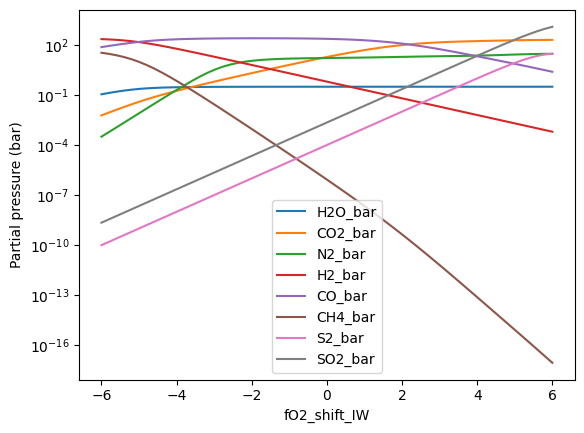

In [84]:
plt.close("all")

# parameters
x_arr = np.linspace(-6, 6, 60)
x_key = "fO2_shift_IW"
y_keys = [v+"_vmr" for v in solvevol_vols]
y_keys.extend([v+"_bar" for v in solvevol_vols])

# run model
y_out = {}
for y in y_keys:
    y_out[y] = []
for x in x_arr:
    OPTIONS = deepcopy(BACKUP_options)
    OPTIONS[x_key] = x
    solvevol_target = get_target_from_params(OPTIONS)
    p_d = equilibrium_atmosphere(solvevol_target, OPTIONS)
    for y in y_keys:
        y_out[y].append(p_d[y])


# plot data
fig,ax = plt.subplots(1,1)

# plot "_vmr" or "_bar"
plot_key = "_bar"

for y in y_keys:
    if plot_key in y:
        ax.plot(x_arr, y_out[y], label=y)
if plot_key == "_vmr":
    ylabel = "Volume mixing ratio"
if plot_key == "_bar":
    ylabel = "Partial pressure (bar)"
ax.set(xlabel=x_key, ylabel=ylabel)
ax.legend()
ax.set_yscale("log")

plt.savefig("nogit_SolveVol.pdf")
plt.show()


# write to csv
M = []
header = x_key
M.append(x_arr)
for y in y_keys:
    M.append(y_out[y])
    header += " "+y
M = np.array(M).T
np.savetxt("nogit_SolveVol.csv", M, fmt="%.4e", header=header, comments="")

TOI-1726c parameter sweep

Gravity = 26.155 m.s-2
Targets:
{'H': 7.749999999999999e+21, 'C': 7.749999999999999e+21, 'N': 6.88676126009875e+20, 'S': 1.897685325004989e+22}
{'M_atm': 1.9171270149254425e+22, 'P_surf': 1379.0016670067237, 'H2O_bar': 0.2918186153081198, 'H2O_kg_atm': 1.095136247610191e+19, 'H2O_kg_liquid': 2.1660092228335888e+22, 'H2O_kg_solid': 0.0, 'H2O_kg_total': 2.167104359081199e+22, 'CO2_bar': 0.005613088754905227, 'CO2_kg_atm': 5.145972048300897e+17, 'CO2_kg_liquid': 1.962273235753614e+17, 'CO2_kg_solid': 0.0, 'CO2_kg_total': 7.108245284054511e+17, 'H2_bar': 1092.6675365585045, 'H2_kg_atm': 4.588459062417121e+21, 'H2_kg_liquid': 0.0, 'H2_kg_solid': 0.0, 'H2_kg_total': 4.588459062417121e+21, 'CH4_bar': 84.95602990725631, 'CH4_kg_atm': 2.838655685561615e+21, 'CH4_kg_liquid': 8.995534315718898e+19, 'CH4_kg_solid': 0.0, 'CH4_kg_total': 2.928611028718804e+21, 'CO_bar': 201.07942852748678, 'CO_kg_atm': 1.1732617061213573e+22, 'CO_kg_liquid': 1.2260406856153267e+21, 'CO_kg_solid': 0.0, 'CO_kg_total':

/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:226: RuntimeWarning: overflow encountered in exp
  ppmw  = pb_N2**0.5 * np.exp(5908.0 * pb_tot**0.5/temp - 1.6*fO2_shift)
/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:309: RuntimeWarning: invalid value encountered in scalar power
  p_d['SO2']  = (gamma*pin['S2']*p_d['O2']**2)**0.5
/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:226: RuntimeWarning: invalid value encountered in scalar power
  ppmw  = pb_N2**0.5 * np.exp(5908.0 * pb_tot**0.5/temp - 1.6*fO2_shift)
/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:121: RuntimeWarning: invalid value encountered in scalar power
  return const*p**exponent
/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:253: RuntimeWarning: invalid value encountered in log10
  ppmw = 10 ** (-0.738 + 0.876 * np.log10(p) - 5.44e-5 * p_total)
/Users/timlichtenberg/git

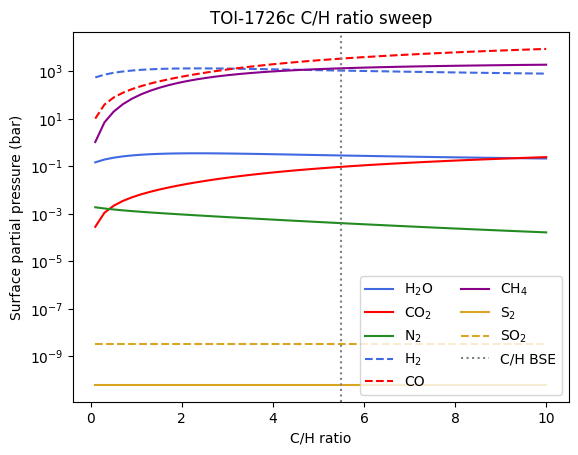

/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:309: RuntimeWarning: invalid value encountered in scalar power
  p_d['SO2']  = (gamma*pin['S2']*p_d['O2']**2)**0.5
/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:226: RuntimeWarning: invalid value encountered in scalar power
  ppmw  = pb_N2**0.5 * np.exp(5908.0 * pb_tot**0.5/temp - 1.6*fO2_shift)
/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:253: RuntimeWarning: invalid value encountered in log10
  ppmw = 10 ** (-0.738 + 0.876 * np.log10(p) - 5.44e-5 * p_total)
/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:226: RuntimeWarning: overflow encountered in exp
  ppmw  = pb_N2**0.5 * np.exp(5908.0 * pb_tot**0.5/temp - 1.6*fO2_shift)
/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:121: RuntimeWarning: invalid value encountered in scalar power
  return const*p**exponent
/Users/timlichtenberg/git

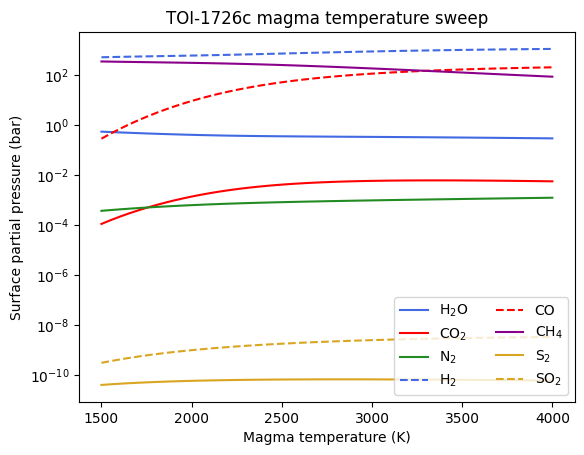

/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:226: RuntimeWarning: overflow encountered in exp
  ppmw  = pb_N2**0.5 * np.exp(5908.0 * pb_tot**0.5/temp - 1.6*fO2_shift)
/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:309: RuntimeWarning: invalid value encountered in scalar power
  p_d['SO2']  = (gamma*pin['S2']*p_d['O2']**2)**0.5
/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:226: RuntimeWarning: invalid value encountered in scalar power
  ppmw  = pb_N2**0.5 * np.exp(5908.0 * pb_tot**0.5/temp - 1.6*fO2_shift)
/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:121: RuntimeWarning: invalid value encountered in scalar power
  return const*p**exponent
/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:253: RuntimeWarning: invalid value encountered in log10
  ppmw = 10 ** (-0.738 + 0.876 * np.log10(p) - 5.44e-5 * p_total)
/Users/timlichtenberg/git

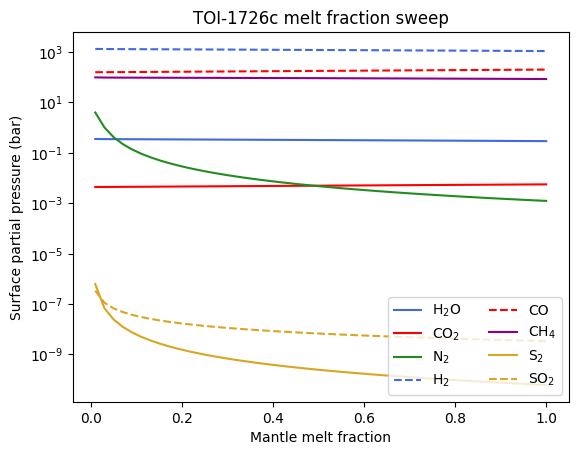

/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:309: RuntimeWarning: invalid value encountered in scalar power
  p_d['SO2']  = (gamma*pin['S2']*p_d['O2']**2)**0.5
/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:121: RuntimeWarning: invalid value encountered in scalar power
  return const*p**exponent
/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:226: RuntimeWarning: invalid value encountered in scalar power
  ppmw  = pb_N2**0.5 * np.exp(5908.0 * pb_tot**0.5/temp - 1.6*fO2_shift)
/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:226: RuntimeWarning: overflow encountered in exp
  ppmw  = pb_N2**0.5 * np.exp(5908.0 * pb_tot**0.5/temp - 1.6*fO2_shift)
/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:253: RuntimeWarning: invalid value encountered in log10
  ppmw = 10 ** (-0.738 + 0.876 * np.log10(p) - 5.44e-5 * p_total)
/Users/timlichtenberg/git

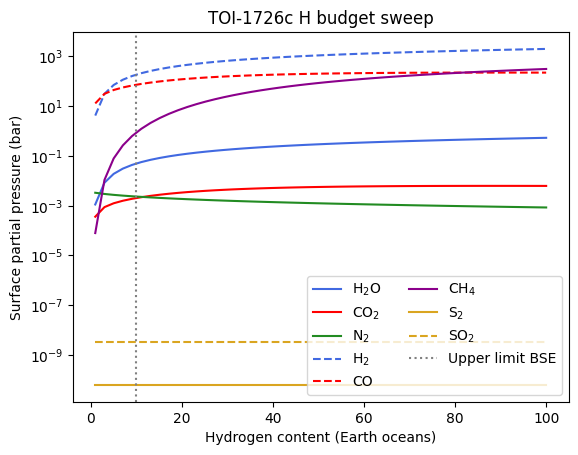

/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:309: RuntimeWarning: invalid value encountered in scalar power
  p_d['SO2']  = (gamma*pin['S2']*p_d['O2']**2)**0.5
/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:226: RuntimeWarning: overflow encountered in exp
  ppmw  = pb_N2**0.5 * np.exp(5908.0 * pb_tot**0.5/temp - 1.6*fO2_shift)
/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:121: RuntimeWarning: invalid value encountered in scalar power
  return const*p**exponent
/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:226: RuntimeWarning: invalid value encountered in scalar power
  ppmw  = pb_N2**0.5 * np.exp(5908.0 * pb_tot**0.5/temp - 1.6*fO2_shift)
/Users/timlichtenberg/git/PROTEUS/tools/../src/proteus/utils/surface_gases.py:253: RuntimeWarning: invalid value encountered in log10
  ppmw = 10 ** (-0.738 + 0.876 * np.log10(p) - 5.44e-5 * p_total)
/Users/timlichtenberg/git

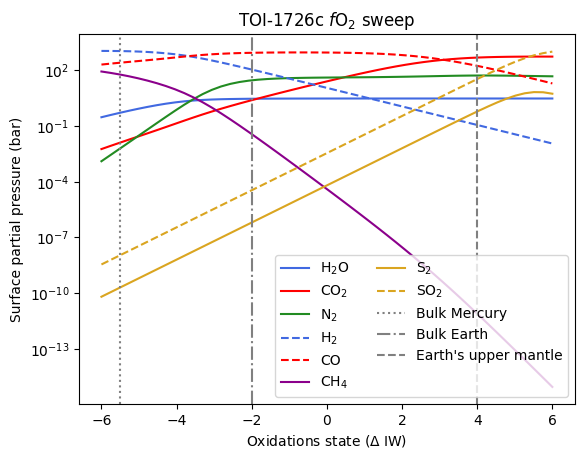

In [154]:
# Set conditions

OPTIONS = {}

# Base settings
OPTIONS['Phi_global']               = 1.0
OPTIONS['T_magma']                  = 4000.0
OPTIONS['radius']                   = 2.67 * 6.371e6 
OPTIONS['mass']                     = 19 * 5.972e24
OPTIONS['gravity']                  = 6.67e-11 * OPTIONS['mass'] / (OPTIONS['radius']**2)
OPTIONS['hydrogen_earth_oceans']    = 50.0    # <10/BSE, <100/BulkEarth
OPTIONS['CH_ratio']                 = 1.0     # 5.5/BSE, 5.77/BulkEarth (Krijt+23/PP7)
OPTIONS['fO2_shift_IW']             = -6.0    # -6.0 ~ Mercury, +4.0 ~ Earth's upper mantle 
OPTIONS['nitrogen_ppmw']            = 9.0     # ~9/BSE, 69/BulkEarth (Krijt+23/PP7)
OPTIONS['sulfur_ppmw']              = 248.0   # 248/BSE, 7444/BulkEarth (Krijt+23/PP7)
OPTIONS['planet_coresize']          = 0.55    # 0.55 = fractional size Earth's outer core

solvevol_vols = ['H2O', 'CO2', 'N2', 'H2', 'CO', 'CH4', 'S2', 'SO2']
for v in solvevol_vols:
    OPTIONS[v+"_included"] = 0
    OPTIONS[v+"_initial_bar"] = 0.0

OPTIONS["H2O_included"] = 1
OPTIONS["CO2_included"] = 1
OPTIONS["N2_included"]  = 1
OPTIONS["S2_included"]  = 1
OPTIONS["H2_included"]  = 1
OPTIONS["CO_included"]  = 1
OPTIONS["CH4_included"] = 1
OPTIONS["SO2_included"] = 1

print("Gravity = %.3f m.s-2" % OPTIONS["gravity"])

OPTIONS["M_mantle"] = CalculateMantleMass(OPTIONS["radius"], OPTIONS["mass"], OPTIONS["planet_coresize"])
BACKUP_options = deepcopy(OPTIONS)

solvevol_target = get_target_from_params(OPTIONS)
# solvevol_target = get_target_from_pressures(OPTIONS)

print("Targets:")
print(solvevol_target)

# Solve for partial pressures etc

p_d = equilibrium_atmosphere(solvevol_target, OPTIONS)

print(p_d)

p_bar = {}
for v in volatile_species:
    p_bar[v] = p_d[v+"_bar"]

mubar = 0.0
ptot = 0.0
print("Partial pressures")
for v in solvevol_vols:
    print("    %s : %.3f bar"%(v, p_bar[v]))
    ptot += p_bar[v]
    mubar += p_bar[v]*molar_mass[v]
mubar /= ptot

print("mubar =",mubar)
print("ptot = %.3f bar"%ptot)

m_d = {}
for v in solvevol_vols:
    m_d[v] = p_bar[v]*1.0e5*4*3.14*(molar_mass[v]/mubar)*OPTIONS["radius"]**2.0/OPTIONS["gravity"]

# print(solvevol_atmosphere_mass(p_bar, OPTIONS))

print(" ")
print("Total mass of atmosphere (kg):", m_d)

H_kg = (2*m_d["H2O"]/molar_mass["H2O"] + 2*m_d["H2"]/molar_mass["H2"] + 4*m_d["CH4"]/molar_mass["CH4"]) *molar_mass['H']
C_kg = (m_d["CO2"]/molar_mass["CO2"] + m_d["CO"]/molar_mass["CO"] + m_d["CH4"]/molar_mass["CH4"]) * molar_mass['C']
N_kg = m_d["N2"]
S_kg = m_d["S2"]

print("H_kg", "C_kg", "N_kg", "S_kg", H_kg, C_kg, N_kg, S_kg)


# Check results
H_mol = H_kg / (1.0e-3)
H_oc  = H_mol / (7.69e22 * 2.0)
print("[H] atm = %.4f" % H_oc)
print("C/H atm = %.4f" % (C_kg/H_kg))

# Sweep plotting routine

for sweep_param in [ "CH_ratio", "T_magma", "Phi_global", "hydrogen_earth_oceans", "fO2_shift_IW" ]: 
# "CH_ratio", "T_magma", "Phi_global", "hydrogen_earth_oceans", "fO2_shift_IW"

    plt.close("all")

    # Number of points to sweep
    n_points = 50

    # parameters
    if sweep_param == "CH_ratio":
        x_arr = np.linspace(0.1, 10, n_points)
    if sweep_param == "T_magma":
        x_arr = np.linspace(1500, 4000, n_points)
    if sweep_param == "Phi_global":
        x_arr = np.linspace(0.01, 1, n_points)
    if sweep_param == "hydrogen_earth_oceans":
        x_arr = np.linspace(1, 100, n_points)
    if sweep_param == "fO2_shift_IW":
        x_arr = np.linspace(-6, 6, n_points)
    x_key = sweep_param
    y_keys = [v+"_vmr" for v in solvevol_vols]
    y_keys.extend([v+"_bar" for v in solvevol_vols])

    # run model
    y_out = {}
    for y in y_keys:
        y_out[y] = []
    for x in x_arr:
        OPTIONS = deepcopy(BACKUP_options)
        OPTIONS[x_key] = x
        solvevol_target = get_target_from_params(OPTIONS)
        p_d = equilibrium_atmosphere(solvevol_target, OPTIONS)
        for y in y_keys:
            y_out[y].append(p_d[y])

    # plot data
    fig,ax = plt.subplots(1,1)

    # plot "_vmr" or "_bar"
    plot_key = "_bar"

    for y in y_keys:
        if plot_key in y:

            if y == "H2O_bar":
                color = "royalblue"
                ls  = "-"
                label = r"H$_2$O"
            if y == "H2_bar":
                color = "royalblue"
                ls  = "--"
                label = r"H$_2$"
            if y == "CO2_bar":
                color = "red"
                ls  = "-"  
                label = r"CO$_2$"
            if y == "CO_bar":
                color = "red"
                ls  = "--"
                label = r"CO"
            if y == "N2_bar":
                color = "forestgreen"
                ls  = "-"
                label = r"N$_2$"
            if y == "CH4_bar":
                color = "darkmagenta"
                ls  = "-"
                label = r"CH$_4$"
            if y == "S2_bar":
                color = "goldenrod"
                ls  = "-"
                label = r"S$_2$"
            if y == "SO2_bar":
                color = "goldenrod"
                ls  = "--"
                label = r"SO$_2$"

            ax.plot(x_arr, y_out[y], label=label, color=color, linestyle=ls)

    if plot_key == "_vmr":
        ylabel = "Volume mixing ratio"
    if plot_key == "_bar":
        ylabel = "Surface partial pressure (bar)"

    if sweep_param == "CH_ratio": # "T_magma", "Phi_global", "hydrogen_earth_oceans", "fO2_shift_IW"
        ax.axvline(5.5, color="grey", linestyle=":", label="C/H BSE")
        sweep_title = "C/H ratio"
        sweep_axis = "C/H ratio"
    if sweep_param == "T_magma":
        sweep_title = "magma temperature"
        sweep_axis = "Magma temperature (K)"
    if sweep_param == "Phi_global":
        sweep_title = "melt fraction"
        sweep_axis = "Mantle melt fraction"
    if sweep_param == "hydrogen_earth_oceans":
        sweep_title = "H budget"
        sweep_axis = "Hydrogen content (Earth oceans)"
        ax.axvline(10, color="grey", linestyle=":", label="Upper limit BSE")
    if sweep_param == "fO2_shift_IW":
        sweep_title = r"$f$O$_2$"
        sweep_axis = r"Oxidation state ($\Delta$ IW)"
        ax.axvline(-5.5, color="grey", linestyle=":", label="Bulk Mercury")
        ax.axvline(-2, color="grey", linestyle="-.", label="Bulk Earth")
        ax.axvline(+4, color="grey", linestyle="--", label="Earth's upper mantle")

    ax.set(xlabel=sweep_axis, ylabel=ylabel)
    ax.legend(loc=4, ncol=2)
    ax.set_yscale("log")
    ax.set_title("TOI-1726c "+sweep_title+" sweep")

    plt.savefig("nogit_TOI-1726c_"+sweep_param+"_sweep.pdf")
    plt.show()

    # write to csv
    M = []
    header = x_key
    M.append(x_arr)
    for y in y_keys:
        M.append(y_out[y])
        header += " "+y
    M = np.array(M).T
    np.savetxt("nogit_TOI-1726c_"+sweep_param+"_sweep.csv", M, fmt="%.4e", header=header, comments="")